# Setup

In [ ]:
# ================================================================================
# CÉLULA 1: INSTALAÇÃO
# ================================================================================
%pip install tabm rtdl_num_embeddings optuna

In [3]:
# ================================================================================
# CÉLULA 2: IMPORTS E CONFIGURAÇÕES
# ================================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import warnings
import optuna

import json
import os

try:
    from tabm import TabM
    from rtdl_num_embeddings import PiecewiseLinearEmbeddings
    print("TabM e rtdl_num_embeddings importados com sucesso!")
except ImportError as e:
    print(f"Bibliotecas não encontradas: {e}")

warnings.filterwarnings('ignore')

# Configurações
N_SPLITS = 10
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {DEVICE}")

# URL do dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nomes das colunas
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

TabM e rtdl_num_embeddings importados com sucesso!
Usando dispositivo: cpu


# EDA e Pré-Processamento

Shape numérico: (297, 5)
Shape categórico: (297, 8)
Cardinalidades: [2, 4, 2, 3, 2, 3, 4, 3]
Distribuição do target: [160 137]


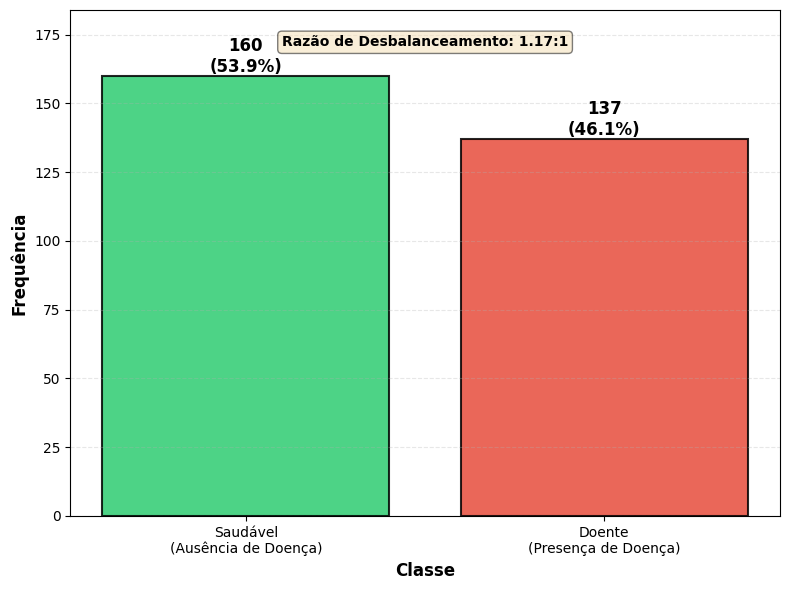


Resumo da Distribuição:
  Classe 0 (Saudável): 160 (53.9%)
  Classe 1 (Doente): 137 (46.1%)
  Razão: 1.17:1


In [4]:
# ================================================================================
# CÉLULA 3: CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS
# ================================================================================
def load_and_process_data(url, columns):
    # Carregar dados
    # O dataset tem valores ausentes marcados com '?'
    df = pd.read_csv(url, names=columns, na_values='?')
    
    # Tratar valores ausentes (remoção simples para este MVP)
    df = df.dropna()
    
    # Converter target para binário (0 = ausência, 1-4 = presença)
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Separar features numéricas e categóricas
    # Numéricas: age, trestbps, chol, thalach, oldpeak
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    # Categóricas: sex, cp, fbs, restecg, exang, slope, ca, thal
    cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # Padronizar features numéricas
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    
    # Codificar categóricas para índices (0 a C-1) para uso com TabM
    cat_cardinalities = []
    for col in cat_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        cat_cardinalities.append(len(le.classes_))
    
    X_num = df[num_features].values.astype(np.float32)
    X_cat = df[cat_features].values.astype(np.int64)
    y = df['target'].values.astype(np.float32).reshape(-1, 1)
    
    return X_num, X_cat, y, num_features, cat_features, cat_cardinalities

X_num, X_cat, y, feature_names_num, feature_names_cat, cat_cardinalities = load_and_process_data(url, columns)

print(f"Shape numérico: {X_num.shape}")
print(f"Shape categórico: {X_cat.shape}")
print(f"Cardinalidades: {cat_cardinalities}")
print(f"Distribuição do target: {np.bincount(y.flatten().astype(int))}")

# ================================================================================
# PLOT: DISTRIBUIÇÃO DO TARGET
# ================================================================================

# Calcular frequências
target_counts = np.bincount(y.flatten().astype(int))
labels = ['Saudável\n(Ausência de Doença)', 'Doente\n(Presença de Doença)']
percentages = (target_counts / target_counts.sum()) * 100

# Criar figura
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de barras
bars = ax.bar(labels, target_counts, color=['#2ecc71', '#e74c3c'], 
              edgecolor='black', linewidth=1.5, alpha=0.85)

# Adicionar valores e percentuais nas barras
for bar, count, pct in zip(bars, target_counts, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configurações do gráfico
ax.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax.set_xlabel('Classe', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, max(target_counts) * 1.15])

# Adicionar informação adicional
ratio = target_counts[0] / target_counts[1]
ax.text(0.5, 0.95, f'Razão de Desbalanceamento: {ratio:.2f}:1', 
        transform=ax.transAxes, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nResumo da Distribuição:")
print(f"  Classe 0 (Saudável): {target_counts[0]} ({percentages[0]:.1f}%)")
print(f"  Classe 1 (Doente): {target_counts[1]} ({percentages[1]:.1f}%)")
print(f"  Razão: {ratio:.2f}:1")

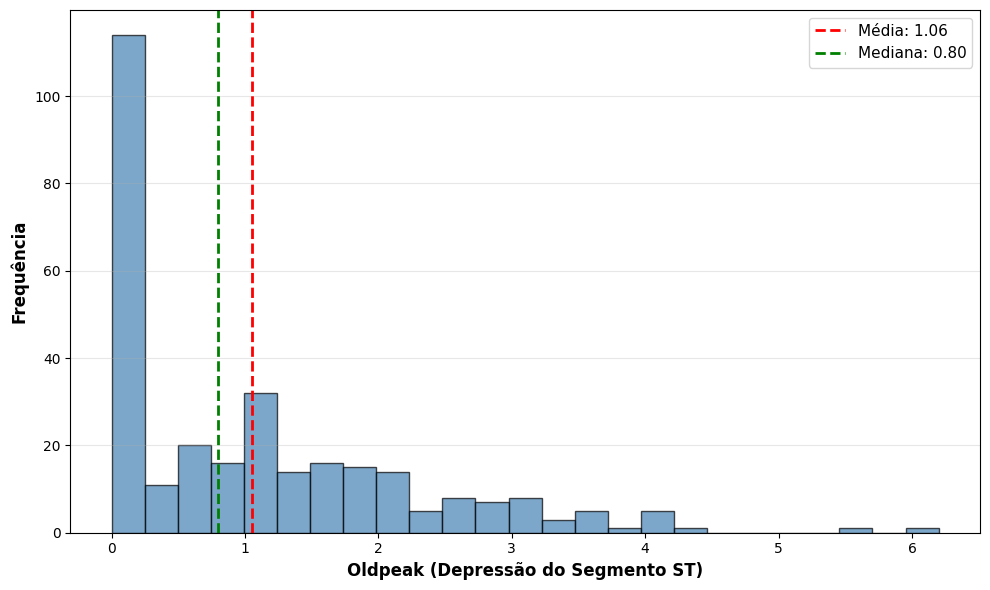

OLDPEAK - Estatísticas Descritivas
Média: 1.0556
Mediana: 0.8000
Desvio Padrão: 1.1661
Mínimo: 0.0000
Máximo: 6.2000
Assimetria: Distribuição concentrada em valores próximos a zero com cauda longa



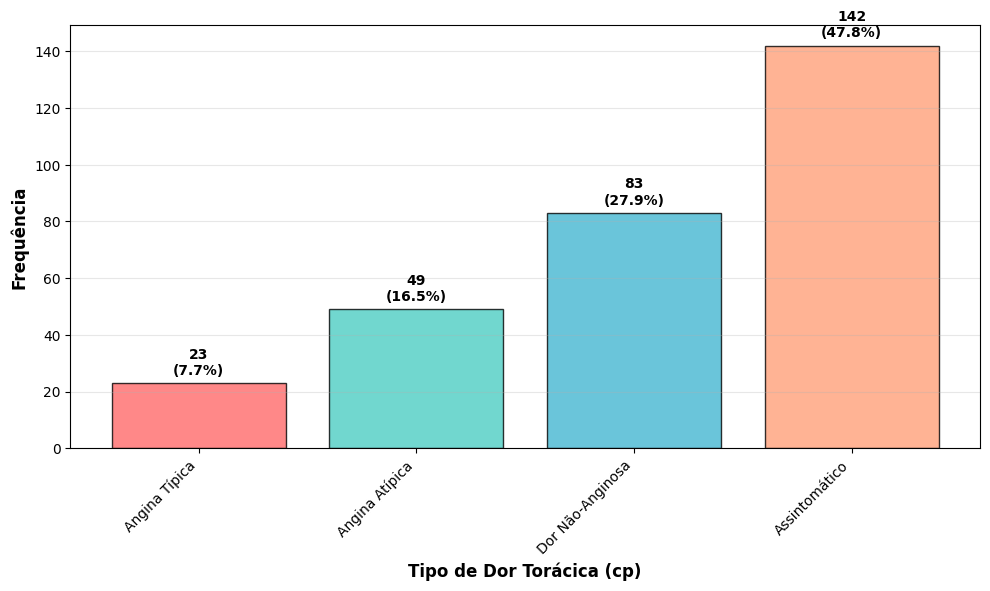

CP (Tipo de Dor Torácica) - Distribuição de Frequências
Angina Típica: 23 amostras (7.7%)
Angina Atípica: 49 amostras (16.5%)
Dor Não-Anginosa: 83 amostras (27.9%)
Assintomático: 142 amostras (47.8%)



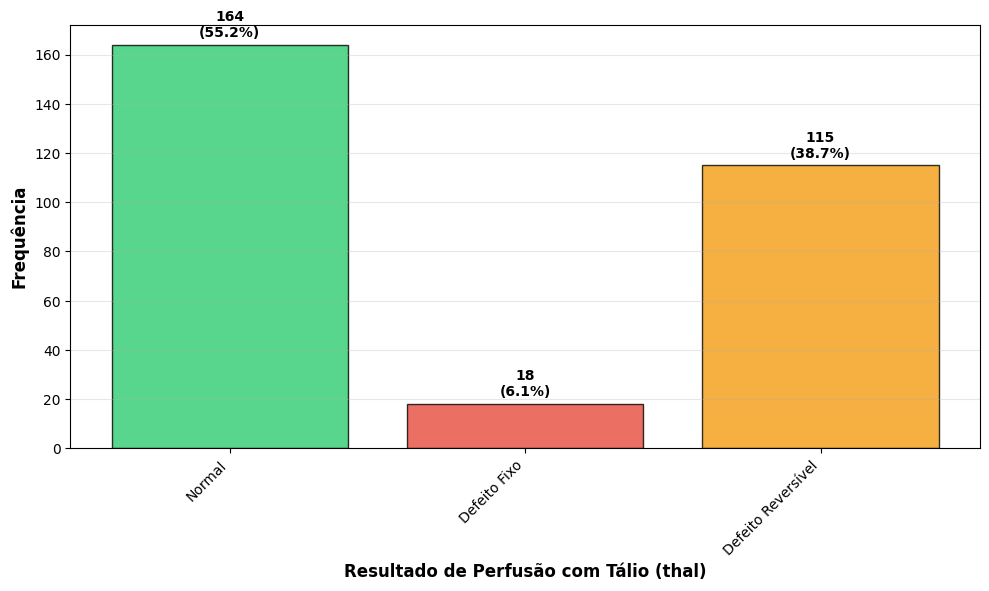

THAL (Resultado de Perfusão com Tálio) - Distribuição de Frequências
Normal: 164 amostras (55.2%)
Defeito Fixo: 18 amostras (6.1%)
Defeito Reversível: 115 amostras (38.7%)



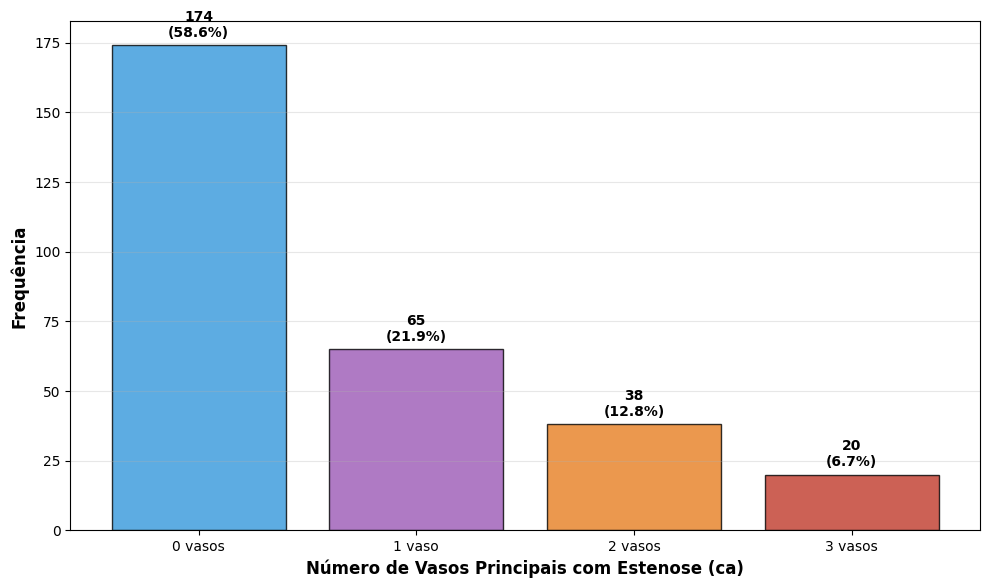

CA (Número de Vasos com Estenose) - Distribuição de Frequências
0 vasos: 174 amostras (58.6%)
1 vaso: 65 amostras (21.9%)
2 vasos: 38 amostras (12.8%)
3 vasos: 20 amostras (6.7%)
Observação: Concentração forte em valores baixos (0 e 1)



In [5]:
# ================================================================================
# CÉLULA 3.1: ANÁLISE DE DISTRIBUIÇÕES
# ================================================================================
# Recarregar dados originais (antes da seleção de features) para análise completa
def load_original_data(url, columns):
    df = pd.read_csv(url, names=columns, na_values='?')
    df = df.dropna()
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # NÃO padronizar para visualização
    X_num_orig = df[num_features].values.astype(np.float32)
    X_cat_orig = df[cat_features].values.astype(np.int64)
    y_orig = df['target'].values.astype(np.float32).reshape(-1, 1)
    
    return X_num_orig, X_cat_orig, y_orig, num_features, cat_features, df

X_num_orig, X_cat_orig, y_orig, num_features_orig, cat_features_orig, df_orig = load_original_data(url, columns)

# ================================================================================
# PLOT 1: OLDPEAK (Feature Numérica - Assimétrica à Direita)
# ================================================================================
plt.figure(figsize=(10, 6))
plt.hist(df_orig['oldpeak'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Oldpeak (Depressão do Segmento ST)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Adicionar estatísticas
mean_val = df_orig['oldpeak'].mean()
median_val = df_orig['oldpeak'].median()
std_val = df_orig['oldpeak'].std()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("OLDPEAK - Estatísticas Descritivas")
print("="*60)
print(f"Média: {mean_val:.4f}")
print(f"Mediana: {median_val:.4f}")
print(f"Desvio Padrão: {std_val:.4f}")
print(f"Mínimo: {df_orig['oldpeak'].min():.4f}")
print(f"Máximo: {df_orig['oldpeak'].max():.4f}")
print(f"Assimetria: Distribuição concentrada em valores próximos a zero com cauda longa")
print("="*60 + "\n")

# ================================================================================
# PLOT 2: CP (Tipo de Dor Torácica - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
cp_counts = df_orig['cp'].value_counts().sort_index()
cp_labels = ['Angina Típica', 'Angina Atípica', 'Dor Não-Anginosa', 'Assintomático']
colors_cp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = plt.bar(range(len(cp_counts)), cp_counts.values, color=colors_cp, edgecolor='black', alpha=0.8)
plt.xlabel('Tipo de Dor Torácica (cp)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(cp_counts)), cp_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, cp_counts.values)):
    pct = count / cp_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("CP (Tipo de Dor Torácica) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(cp_counts.items()):
    pct = count / cp_counts.sum() * 100
    print(f"{cp_labels[i]}: {count} amostras ({pct:.1f}%)")
print("="*60 + "\n")

# ================================================================================
# PLOT 3: THAL (Resultado de Perfusão com Tálio - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
thal_counts = df_orig['thal'].value_counts().sort_index()
thal_labels = ['Normal', 'Defeito Fixo', 'Defeito Reversível']
colors_thal = ['#2ECC71', '#E74C3C', '#F39C12']
bars = plt.bar(range(len(thal_counts)), thal_counts.values, color=colors_thal, edgecolor='black', alpha=0.8)
plt.xlabel('Resultado de Perfusão com Tálio (thal)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(thal_counts)), thal_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, thal_counts.values)):
    pct = count / thal_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("THAL (Resultado de Perfusão com Tálio) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(thal_counts.items()):
    pct = count / thal_counts.sum() * 100
    print(f"{thal_labels[i]}: {count} amostras ({pct:.1f}%)")
print("="*60 + "\n")

# ================================================================================
# PLOT 4: CA (Número de Vasos com Estenose - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
ca_counts = df_orig['ca'].value_counts().sort_index()
ca_labels = ['0 vasos', '1 vaso', '2 vasos', '3 vasos']
colors_ca = ['#3498DB', '#9B59B6', '#E67E22', '#C0392B']
bars = plt.bar(range(len(ca_counts)), ca_counts.values, color=colors_ca, edgecolor='black', alpha=0.8)
plt.xlabel('Número de Vasos Principais com Estenose (ca)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(ca_counts)), ca_labels)
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, ca_counts.values)):
    pct = count / ca_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("CA (Número de Vasos com Estenose) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(ca_counts.items()):
    pct = count / ca_counts.sum() * 100
    print(f"{ca_labels[i]}: {count} amostras ({pct:.1f}%)")
print("Observação: Concentração forte em valores baixos (0 e 1)")
print("="*60 + "\n")

In [6]:
# ================================================================================
# CÉLULA 3.2: SELEÇÃO DE FEATURES (CONFIGURAÇÃO FINAL)
# ================================================================================
def select_features(X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities, features_to_remove):
    print(f"\n>>> Realizando Seleção de Features <<<")
    print(f"Features originais: {len(feature_names_num) + len(feature_names_cat)}")
    print(f"Removendo: {features_to_remove}")
    
    # Identificar índices para manter
    keep_num_indices = [i for i, f in enumerate(feature_names_num) if f not in features_to_remove]
    keep_cat_indices = [i for i, f in enumerate(feature_names_cat) if f not in features_to_remove]
    
    # Filtrar arrays
    X_num_selected = X_num[:, keep_num_indices]
    X_cat_selected = X_cat[:, keep_cat_indices]
    
    # Atualizar nomes
    new_feature_names_num = [feature_names_num[i] for i in keep_num_indices]
    new_feature_names_cat = [feature_names_cat[i] for i in keep_cat_indices]
    
    # Atualizar cardinalidades para as categóricas mantidas
    new_cat_cardinalities = [cat_cardinalities[i] for i in keep_cat_indices]
    
    return X_num_selected, X_cat_selected, new_feature_names_num, new_feature_names_cat, new_cat_cardinalities

# Lista Final de Features para remover (Mantendo apenas oldpeak, cp, exang, slope, ca, thal)
features_to_drop = ['sex', 'age', 'trestbps', 'restecg', 'fbs', 'thalach', 'chol']

X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities = select_features(
    X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities, features_to_drop
)

print(f"Shape numérico atualizado: {X_num.shape}")
print(f"Shape categórico atualizado: {X_cat.shape}")
print(f"Features Numéricas restantes: {feature_names_num}")
print(f"Features Categóricas restantes: {feature_names_cat}")
print(f"Cardinalidades atualizadas: {cat_cardinalities}")


>>> Realizando Seleção de Features <<<
Features originais: 13
Removendo: ['sex', 'age', 'trestbps', 'restecg', 'fbs', 'thalach', 'chol']
Shape numérico atualizado: (297, 1)
Shape categórico atualizado: (297, 5)
Features Numéricas restantes: ['oldpeak']
Features Categóricas restantes: ['cp', 'exang', 'slope', 'ca', 'thal']
Cardinalidades atualizadas: [4, 2, 3, 4, 3]


In [7]:
# ================================================================================
# CÉLULA SMOTE
# ================================================================================


def smote_hybrid(X_num, X_cat, y, sampling_strategy=0.5, k_neighbors=5, random_state=42):
    """
    Implementa SMOTE híbrido para dados mistos (numéricos + categóricos).
    
    Args:
        X_num: Array de features numéricas (n_samples, n_num_features)
        X_cat: Array de features categóricas (n_samples, n_cat_features)
        y: Array de labels (n_samples,)
        sampling_strategy: Razão de oversampling (0.5 = 50% da classe majoritária)
        k_neighbors: Número de vizinhos para KNN
        random_state: Seed para reprodutibilidade
        
    Returns:
        X_num_smote, X_cat_smote, y_smote: Dados aumentados com amostras sintéticas
    """
    np.random.seed(random_state)
    
    # Identificar classes
    unique_classes = np.unique(y)
    if len(unique_classes) != 2:
        raise ValueError("SMOTE requer classificação binária")
    
    # Classe minoritária e majoritária
    class_counts = np.bincount(y.astype(int).flatten())
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)
    
    minority_mask = (y == minority_class).flatten()
    majority_mask = (y == majority_class).flatten()
    
    X_num_minority = X_num[minority_mask]
    X_cat_minority = X_cat[minority_mask]
    y_minority = y[minority_mask]
    
    n_minority = X_num_minority.shape[0]
    n_majority = np.sum(majority_mask)
    
    # Calcular número de amostras sintéticas a gerar
    n_synthetic = max(0, int((n_majority * sampling_strategy) - n_minority))
    
    if n_synthetic == 0:
        print(f"SMOTE: Sem necessidade de oversampling (minoritária: {n_minority}, majoritária: {n_majority})")
        return X_num, X_cat, y
    
    print(f"SMOTE: Gerando {n_synthetic} amostras sintéticas")
    print(f"  Classe minoritária: {minority_class} ({n_minority} amostras)")
    print(f"  Classe majoritária: {majority_class} ({n_majority} amostras)")
    
    # Normalizar features numéricas para KNN (escala 0-1)
    X_num_min_norm = (X_num_minority - X_num_minority.min(axis=0)) / (X_num_minority.max(axis=0) - X_num_minority.min(axis=0) + 1e-8)
    
    # Encontrar k vizinhos mais próximos (usando apenas features numéricas para distância)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(X_num_min_norm)
    distances, indices = nbrs.kneighbors(X_num_min_norm)
    
    # Gerar amostras sintéticas
    X_num_synthetic = []
    X_cat_synthetic = []
    
    for _ in range(n_synthetic):
        # Selecionar aleatoriamente uma amostra minoritária
        idx_minority = np.random.randint(0, n_minority)
        
        # Selecionar aleatoriamente um vizinho (excluindo o próprio índice)
        neighbor_idx = np.random.choice(indices[idx_minority][1:])
        
        # Interpolação linear para features numéricas
        alpha = np.random.rand(X_num_minority.shape[1])
        X_num_new = X_num_minority[idx_minority] + alpha * (X_num_minority[neighbor_idx] - X_num_minority[idx_minority])
        
        # Para features categóricas: selecionar aleatoriamente entre as duas amostras
        X_cat_new = np.where(
            np.random.rand(X_cat_minority.shape[1]) > 0.5,
            X_cat_minority[idx_minority],
            X_cat_minority[neighbor_idx]
        )
        
        X_num_synthetic.append(X_num_new)
        X_cat_synthetic.append(X_cat_new)
    
    # Concatenar dados originais com sintéticos
    X_num_smote = np.vstack([X_num, np.array(X_num_synthetic)])
    X_cat_smote = np.vstack([X_cat, np.array(X_cat_synthetic)])
    y_smote = np.vstack([y, np.full((n_synthetic, 1), minority_class)])
    
    print(f"  Dataset original: {X_num.shape[0]} amostras")
    print(f"  Dataset com SMOTE: {X_num_smote.shape[0]} amostras")
    print(f"  Nova distribuição: {np.bincount(y_smote.astype(int).flatten())}")
    
    return X_num_smote, X_cat_smote, y_smote

print("\n>>> TESTE DE SMOTE <<<")
print("Usando sampling_strategy=1.0")
X_num_test, X_cat_test, y_test = smote_hybrid(X_num, X_cat, y, sampling_strategy=1.0, k_neighbors=5)
print(f"\nDistribuição original: {np.bincount(y.astype(int).flatten())}")
print(f"Distribuição com SMOTE: {np.bincount(y_test.astype(int).flatten())}")
print(f"Amostras sintéticas geradas: {y_test.shape[0] - y.shape[0]}")


>>> TESTE DE SMOTE <<<
Usando sampling_strategy=1.0
SMOTE: Gerando 23 amostras sintéticas
  Classe minoritária: 1 (137 amostras)
  Classe majoritária: 0 (160 amostras)
  Dataset original: 297 amostras
  Dataset com SMOTE: 320 amostras
  Nova distribuição: [160 160]

Distribuição original: [160 137]
Distribuição com SMOTE: [160 160]
Amostras sintéticas geradas: 23


# Training

In [8]:
# ================================================================================
# CÉLULA 4: DEFINIÇÃO DO MODELO E FUNÇÕES DE TREINAMENTO
# ================================================================================
import rtdl_num_embeddings

def create_tabm_model(n_num_features, cat_cardinalities, params, X_train=None, d_out=1):
    """
    Cria o modelo TabM com hiperparâmetros dinâmicos.
    Adiciona suporte a Embeddings Numéricos se especificado.
    """
    
    # Configuração de Embeddings Numéricos
    num_embeddings = None
    if params.get('use_embeddings', False) and X_train is not None:
        # Usando PiecewiseLinearEmbeddings com cálculo de bins
        bins = rtdl_num_embeddings.compute_bins(X_train, n_bins=params['n_bins'])
        
        num_embeddings = PiecewiseLinearEmbeddings(
            bins=bins,
            d_embedding=params['d_embedding'],
            activation=True,
            version='B'
        )

    model = TabM.make(
        n_num_features=n_num_features,
        cat_cardinalities=cat_cardinalities,
        d_out=d_out,
        n_blocks=params['n_blocks'],
        d_block=params['d_block'],
        dropout=params.get('dropout', 0.1),
        num_embeddings=num_embeddings
    )
    return model

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for X_num_batch, X_cat_batch, y_batch in loader:
        X_num_batch = X_num_batch.to(device).float()
        X_cat_batch = X_cat_batch.to(device)
        y_batch = y_batch.to(device).float()
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_num_batch, X_cat_batch)
        
        # Loss média das k predições independentes
        y_target_expanded = y_batch.unsqueeze(1).expand(-1, model.k, -1)
        loss = criterion(y_pred.reshape(-1, 1), y_target_expanded.reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_num_batch.size(0)
        
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_num_batch, X_cat_batch, y_batch in loader:
            X_num_batch = X_num_batch.to(device).float()
            X_cat_batch = X_cat_batch.to(device)
            
            # Ensemble mean na inferência
            y_pred = model(X_num_batch, X_cat_batch)
            probs = torch.sigmoid(y_pred).mean(dim=1)
            
            all_preds.append(probs.cpu().numpy())
            all_targets.append(y_batch.numpy())
            
    return np.vstack(all_preds), np.vstack(all_targets)

# Fine-Tunning

In [ ]:
# ================================================================================
# CÉLULA 5: OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) - COM SMOTE
# ================================================================================


def objective(trial):
    # Espaço de busca sugerido na documentação do TabM
    params = {
        'n_blocks': trial.suggest_int('n_blocks', 1, 4), 
        'd_block': trial.suggest_int('d_block', 64, 512, step=16), 
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        
        # Configurações de Embeddings
        'use_embeddings': True,
        'd_embedding': trial.suggest_int('d_embedding', 8, 32, step=4),
        'n_bins': trial.suggest_int('n_bins', 2, 64),
        
        # Configurações de SMOTE
        'use_smote': True,
        'smote_sampling_strategy': trial.suggest_float('smote_sampling_strategy', 0.86, 1.0)
    }
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    
    for train_idx, val_idx in skf.split(X_num, y):
        # Split simples
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Aplicar SMOTE ao conjunto de treinamento
        if params['use_smote']:
            X_num_train, X_cat_train, y_train = smote_hybrid(
                X_num_train, X_cat_train, y_train,
                sampling_strategy=params['smote_sampling_strategy'],
                k_neighbors=5,
                random_state=RANDOM_STATE
            )
        
        train_ds = TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train))
        val_ds = TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val))
        
        train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
        
        # Passar X_num_train para calcular os bins dos embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        best_fold_auc = 0
        for epoch in range(30):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            try:
                auc = roc_auc_score(val_targets, val_preds)
            except:
                auc = 0.5
            best_fold_auc = max(best_fold_auc, auc)
            
            # Pruning do Optuna
            trial.report(best_fold_auc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        scores.append(best_fold_auc)
    
    return np.mean(scores)

print("Iniciando estudo de otimização com SMOTE (sampling_strategy: 0.86-1.0)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

print("\nMelhores hiperparâmetros:")
best_params = study.best_params
best_params['use_embeddings'] = True 
best_params['use_smote'] = True
print(best_params)

# Salvar em JSON
output_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in dir() else os.getcwd()
os.makedirs(output_dir, exist_ok=True)
json_path = os.path.join(output_dir, 'best_params_tabm.json')

with open(json_path, 'w') as f:
    json.dump(best_params, f, indent=4)
    
print(f"Melhores parâmetros salvos em: {json_path}")

In [9]:
best_params = {}

with open("best_params_tabm.json", "r") as f:
    best_params = json.load(f)
    print(f"Best parameters loaded: {best_params}")

Best parameters loaded: {'n_blocks': 2, 'd_block': 384, 'lr': 0.004005655611200343, 'weight_decay': 0.0030912898654750437, 'dropout': 0.06976094714529132, 'd_embedding': 28, 'n_bins': 17, 'smote_sampling_strategy': 0.9062149113605019, 'use_embeddings': True, 'use_smote': True}


# Evaluation


>>> Rodando Experimento Final com Melhores Parâmetros (com SMOTE) <<<

Fold 1/10
  Aplicando SMOTE...
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 274 amostras
  Nova distribuição: [144 130]
  AUC: 0.9464 | Acc (0.5): 0.8667 | Acc (Opt 0.73): 0.8667

Fold 2/10
  Aplicando SMOTE...
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 274 amostras
  Nova distribuição: [144 130]
  AUC: 0.9710 | Acc (0.5): 0.8667 | Acc (Opt 0.65): 0.9333

Fold 3/10
  Aplicando SMOTE...
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 274 amostras
  Nova distribuição: [144 130]
  AUC: 0.9866 | Acc (0.5): 0.9333 | Acc (Opt 0.50): 0.9333

Fold 4/10
  Apli

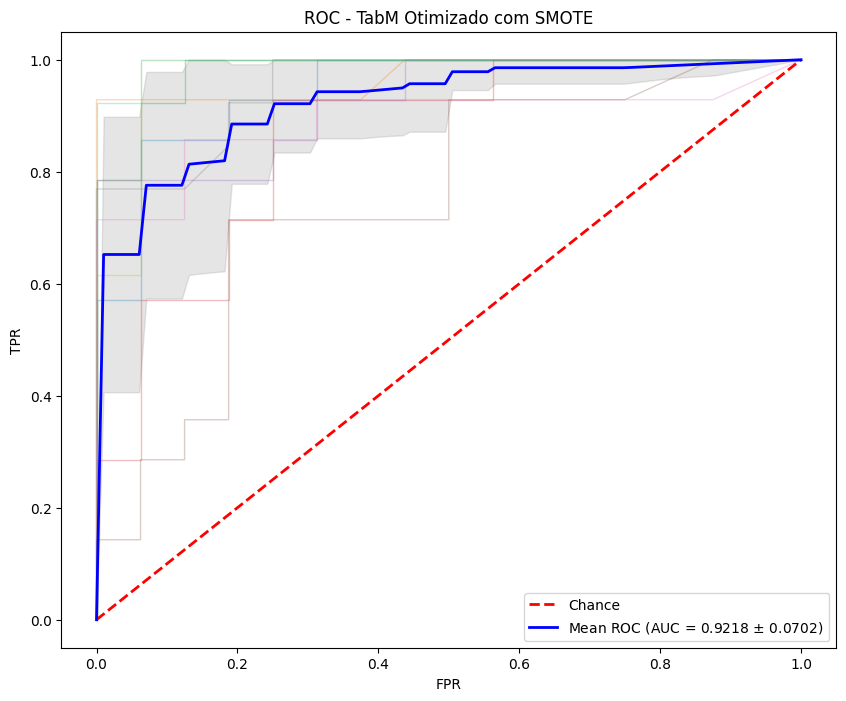


=== RESULTADOS FINAIS ===
Média AUC-ROC: 0.9253 (+/- 0.0702)
Média Accuracy (Threshold 0.5): 0.8152 (+/- 0.0844)
Média Accuracy (Threshold Otimizado): 0.8656 (+/- 0.0610)

=== INFORMAÇÕES DE SMOTE ===
Fold 1: 267 → 274 (+7 sintéticas)
Fold 2: 267 → 274 (+7 sintéticas)
Fold 3: 267 → 274 (+7 sintéticas)
Fold 4: 267 → 274 (+7 sintéticas)
Fold 5: 267 → 274 (+7 sintéticas)
Fold 6: 267 → 274 (+7 sintéticas)
Fold 7: 267 → 274 (+7 sintéticas)
Fold 8: 268 → 274 (+6 sintéticas)
Fold 9: 268 → 274 (+6 sintéticas)
Fold 10: 268 → 274 (+6 sintéticas)

✓ Modelo completo salvo em: tabm_final_model.pth


In [16]:
# ================================================================================
# CÉLULA 6: EXECUÇÃO DO EXPERIMENTO FINAL (COM SMOTE E THRESHOLD OTIMIZADO)
# ================================================================================
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def run_final_experiment(params, save_model=False, model_path='tabm_final_model.pkl'):
    print("\n>>> Rodando Experimento Final com Melhores Parâmetros (com SMOTE) <<<")
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    fold_auc_results = []
    fold_acc_results = []
    fold_opt_acc_results = [] # Acurácia com threshold otimizado
    fold_smote_info = []  # Informações sobre SMOTE por fold
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    best_overall_model = None
    best_overall_model_object = None
    best_overall_auc = 0
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_num, y)):
        print(f"\nFold {fold+1}/{N_SPLITS}")
        
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Aplicar SMOTE ao conjunto de treinamento
        if params.get('use_smote', False):
            print(f"  Aplicando SMOTE...")
            X_num_train_orig_size = X_num_train.shape[0]
            X_num_train, X_cat_train, y_train = smote_hybrid(
                X_num_train, X_cat_train, y_train,
                sampling_strategy=params.get('smote_sampling_strategy', 0.8),
                k_neighbors=5,
                random_state=RANDOM_STATE + fold  # Seed diferente por fold
            )
            fold_smote_info.append({
                'fold': fold + 1,
                'original_size': X_num_train_orig_size,
                'smote_size': X_num_train.shape[0],
                'increase': X_num_train.shape[0] - X_num_train_orig_size
            })
        
        train_loader = DataLoader(TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train)), batch_size=256, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val)), batch_size=256, shuffle=False)
        
        # Passar X_num_train para embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        best_val_auc = 0
        best_epoch_preds = None
        best_epoch_targets = None
        best_model_state = None
        patience = 15 
        no_improve = 0
        
        for epoch in range(100):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            
            try:
                val_auc = roc_auc_score(val_targets, val_preds)
            except:
                val_auc = 0.5
            
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_epoch_preds = val_preds
                best_epoch_targets = val_targets
                best_model_state = model.state_dict() 
                no_improve = 0
            else:
                no_improve += 1
                
            if no_improve >= patience:
                break
            
        if best_val_auc > best_overall_auc:
            best_overall_auc = best_val_auc
            best_overall_model_object = model
            best_overall_model = {
                'params': params,
                'num_features': len(feature_names_num),
                'cat_cardinalities': cat_cardinalities,
                'feature_names_num': feature_names_num,
                'best_auc': best_val_auc,
                'fold': fold + 1,
                'model_state_dict': best_model_state 
            }

        # Calcular métricas finais para o melhor modelo do fold
        if best_epoch_preds is not None:
            # 1. ROC e Threshold Otimizado
            fpr, tpr, thresholds = roc_curve(best_epoch_targets, best_epoch_preds)
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]
            
            # Acurácias
            acc_default = accuracy_score(best_epoch_targets, (best_epoch_preds > 0.5).astype(int))
            acc_opt = accuracy_score(best_epoch_targets, (best_epoch_preds > best_thresh).astype(int))
            
            fold_auc_results.append(best_val_auc)
            fold_acc_results.append(acc_default)
            fold_opt_acc_results.append(acc_opt)
            
            # Plotting
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            ax.plot(fpr, tpr, lw=1, alpha=0.3)
            
            print(f"  AUC: {best_val_auc:.4f} | Acc (0.5): {acc_default:.4f} | Acc (Opt {best_thresh:.2f}): {acc_opt:.4f}")

    # Plot Média
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
    
    ax.set(title="ROC - TabM Otimizado com SMOTE", xlabel='FPR', ylabel='TPR')
    ax.legend(loc="lower right")
    plt.show()

    print(f"\n=== RESULTADOS FINAIS ===")
    print(f"Média AUC-ROC: {np.mean(fold_auc_results):.4f} (+/- {np.std(fold_auc_results):.4f})")
    print(f"Média Accuracy (Threshold 0.5): {np.mean(fold_acc_results):.4f} (+/- {np.std(fold_acc_results):.4f})")
    print(f"Média Accuracy (Threshold Otimizado): {np.mean(fold_opt_acc_results):.4f} (+/- {np.std(fold_opt_acc_results):.4f})")
    
    if fold_smote_info:
        print(f"\n=== INFORMAÇÕES DE SMOTE ===")
        for info in fold_smote_info:
            print(f"Fold {info['fold']}: {info['original_size']} → {info['smote_size']} (+{info['increase']} sintéticas)")
    
    if save_model and best_overall_model is not None and best_overall_model_object is not None:
        best_overall_model_object = best_overall_model_object.cpu()
        best_overall_model_object.eval()
        
        best_overall_model['model'] = best_overall_model_object
        
        torch.save(best_overall_model, model_path)
        print(f"\n✓ Modelo completo salvo em: {model_path}")
    
    return best_overall_model

if 'best_params' in globals():
    final_model = run_final_experiment(best_params, save_model=True, model_path='tabm_final_model.pth')
else:
    print("Execute a célula de otimização primeiro!")

Executando análise no último fold...
Treinando modelo para análise (pode levar alguns segundos)...

>>> Análise de Incerteza e Features <<<


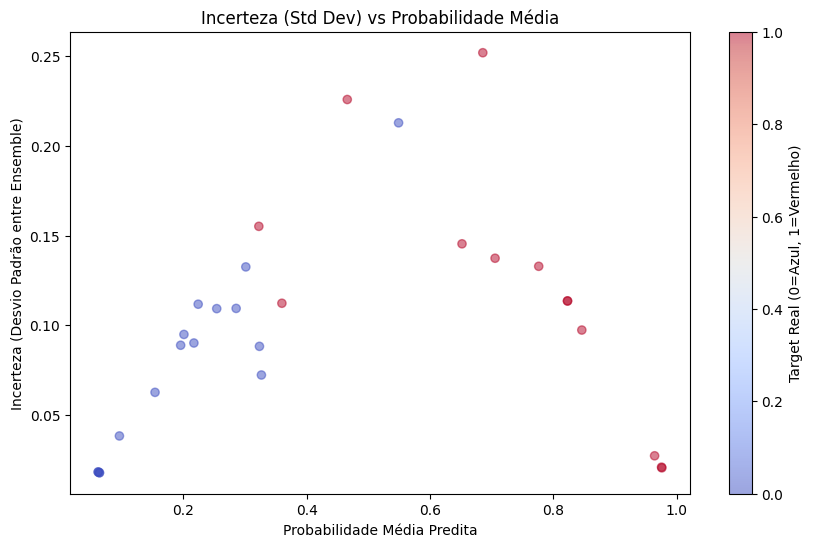

Incerteza média: 0.0979
Exemplo de alta incerteza (Index 0): Prob=0.69, Std=0.25

Calculando Importância de Features (Permutação)...


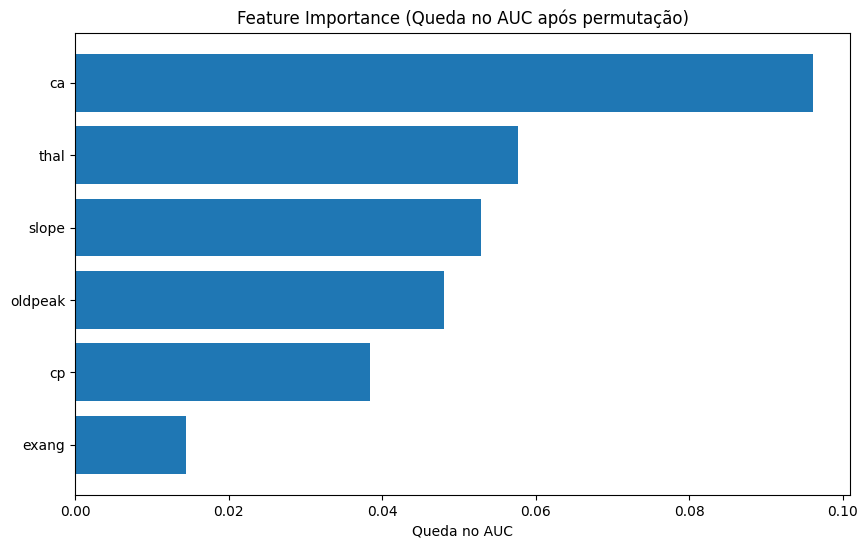

In [ ]:
# ================================================================================
# CÉLULA 7: ESTIMATIVA DE INCERTEZA E IMPORTÂNCIA DE FEATURES
# ================================================================================

def analyze_uncertainty_and_features(model, X_num_val, X_cat_val, y_val, feature_names):
    """
    Analisa a incerteza das predições e a importância das features via permutação.
    """
    print("\n>>> Análise de Incerteza e Features <<<")
    model.eval()
    
    # 1. Incerteza (Desvio Padrão do Ensemble)
    X_num_t = torch.tensor(X_num_val).to(DEVICE)
    X_cat_t = torch.tensor(X_cat_val).to(DEVICE)
    
    with torch.no_grad():
        # Shape: (batch, k, 1)
        y_pred_raw = model(X_num_t, X_cat_t)
        probs_ensemble = torch.sigmoid(y_pred_raw).squeeze(-1).cpu().numpy() # (batch, k)
        
    # Média e Desvio Padrão das probabilidades
    mean_probs = probs_ensemble.mean(axis=1)
    std_probs = probs_ensemble.std(axis=1)
    
    # Plotar relação Probabilidade x Incerteza
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_probs, std_probs, alpha=0.5, c=y_val, cmap='coolwarm')
    plt.colorbar(label='Target Real (0=Azul, 1=Vermelho)')
    plt.title("Incerteza (Std Dev) vs Probabilidade Média")
    plt.xlabel("Probabilidade Média Predita")
    plt.ylabel("Incerteza (Desvio Padrão entre Ensemble)")
    plt.show()
    
    print(f"Incerteza média: {std_probs.mean():.4f}")
    print(f"Exemplo de alta incerteza (Index {np.argmax(std_probs)}): Prob={mean_probs[np.argmax(std_probs)]:.2f}, Std={std_probs.max():.2f}")
    
    # 2. Importância de Features (Permutation Importance)
    print("\nCalculando Importância de Features (Permutação)...")
    baseline_auc = roc_auc_score(y_val, mean_probs)
    importances = {}
    
    # Features Numéricas
    for i, name in enumerate(feature_names[:len(feature_names_num)]): # Assumindo ordem numéricas primeiro
        X_num_permuted = X_num_val.copy()
        np.random.shuffle(X_num_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(torch.tensor(X_num_permuted).to(DEVICE), X_cat_t)
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
            
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Features Categóricas
    for i, name in enumerate(feature_names[len(feature_names_num):]):
        X_cat_permuted = X_cat_val.copy()
        np.random.shuffle(X_cat_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(X_num_t, torch.tensor(X_cat_permuted).to(DEVICE))
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
        
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Plotar Importâncias
    sorted_feats = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    names, vals = zip(*sorted_feats)
    
    plt.figure(figsize=(10, 6))
    plt.barh(names, vals)
    plt.gca().invert_yaxis()
    plt.title("Feature Importance (Queda no AUC após permutação)")
    plt.xlabel("Queda no AUC")
    plt.show()

print("Executando análise no último fold...")
# Recriar split do último fold manualmente para análise
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(skf.split(X_num, y))
last_train_idx, last_val_idx = splits[-1]

X_num_val_last = X_num[last_val_idx]
X_cat_val_last = X_cat[last_val_idx]
y_val_last = y[last_val_idx]


if 'best_params' in globals():
    final_model = create_tabm_model(len(feature_names_num), cat_cardinalities, best_params, X_train=torch.tensor(X_num[last_train_idx])).to(DEVICE)
    # Treino rápido para ter pesos não-aleatórios
    opt = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    crit = nn.BCEWithLogitsLoss()
    loader = DataLoader(TensorDataset(torch.tensor(X_num[last_train_idx]), torch.tensor(X_cat[last_train_idx]), torch.tensor(y[last_train_idx])), batch_size=256, shuffle=True)
    
    print("Treinando modelo para análise")
    for _ in range(50):
        train_epoch(final_model, loader, opt, crit, DEVICE)
        
    all_features = feature_names_num + feature_names_cat
    analyze_uncertainty_and_features(final_model, X_num_val_last, X_cat_val_last, y_val_last, all_features)
else:
    print("Execute a otimização primeiro.")